In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import interpolate
import numpy as np

In [3]:
# Configuration
data_folder = "./data"

# 0. Diagrammes fréquence-rang

## CACM

### Linear scale

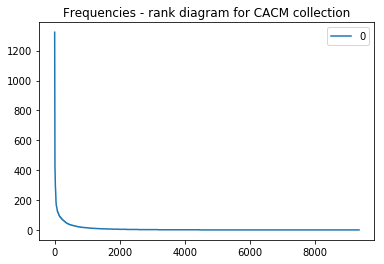

In [8]:
# Load the csv file, then sort it, then update the index regarding the rank
frequencies = pd.read_csv("./frequencies/cacm.csv", header=None).sort_values(0, ascending=False).reset_index(drop=True)
frequencies.plot(title="Frequencies - rank diagram for CACM collection")

### Logarithmic scale

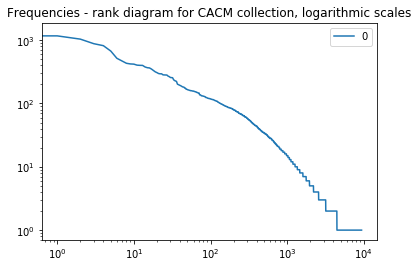

In [9]:
# Load the csv file, then sort it, then update the index regarding the rank
frequencies = pd.read_csv("./frequencies/cacm.csv", header=None).sort_values(0, ascending=False).reset_index(drop=True)
frequencies.plot(title="Frequencies - rank diagram for CACM collection, logarithmic scales", logx=True, logy=True)

## Stanford

### Linear scale

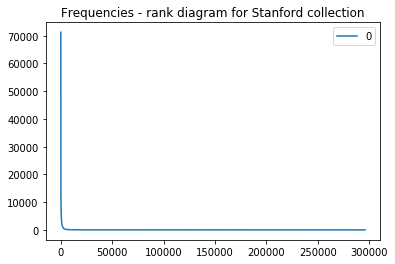

In [17]:
# Load the csv file, then sort it, then update the index regarding the rank
frequencies = pd.read_csv("./frequencies/stanford.csv", header=None).sort_values(0, ascending=False).reset_index(drop=True)
frequencies.plot(title="Frequencies - rank diagram for Stanford collection")

### Logarithmic scale

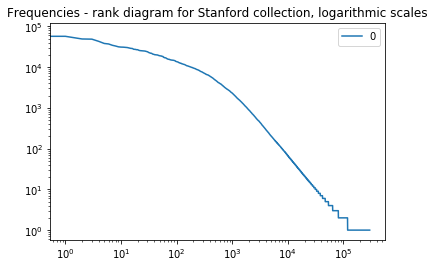

In [10]:
# Load the csv file, then sort it, then update the index regarding the rank
frequencies = pd.read_csv("./frequencies/stanford.csv", header=None).sort_values(0, ascending=False).reset_index(drop=True)
frequencies.plot(title="Frequencies - rank diagram for Stanford collection, logarithmic scales", logx=True, logy=True)

# 1. Courbe rappel-précision

In [53]:
def recall_precision_fig(title, recall_scores, prec_scores, new_fig=True):
    x01_y01_fig(title, "Rappel", recall_scores, "Précision", prec_scores, new_fig=new_fig)
    
def x01_y01_fig(title, xlabel, xscores, ylabel, yscores, new_fig=True, xlim=(0,1), ylim=(0,1)):
    """
    Helper function to plot the curves
    """
    if new_fig:
        plt.figure()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.plot(xscores, yscores)

## Courbes pour chaque requête

NB :
- Certaines requêtes de test ont une liste de documents correspondants vide. La courbe rappel-précision est alors nécessairement sur la droite y(x)=0.
- Une des requêtes de test a une liste de documents correspondants de taille 1. La courbe est ici verticale, parce que le document avec le meilleur score est ce document.

/home/robin/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


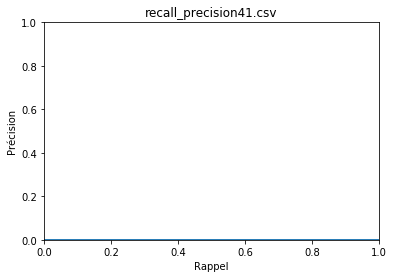

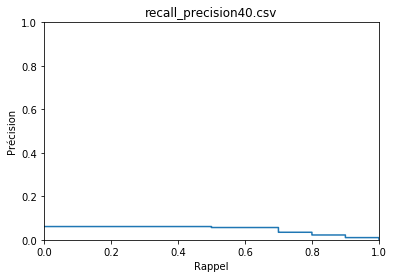

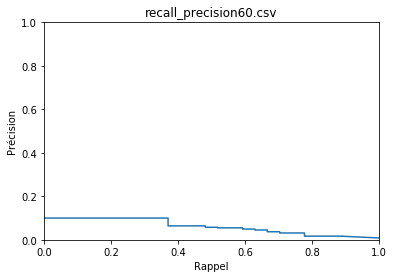

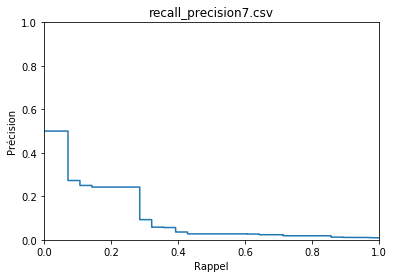

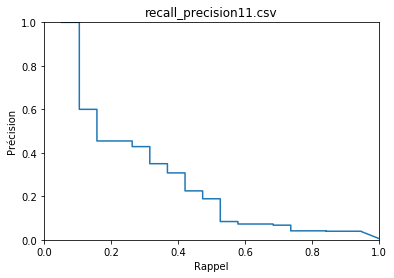

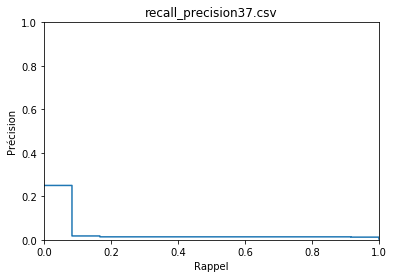

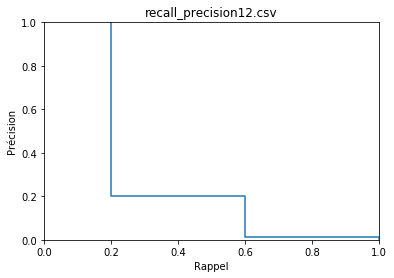

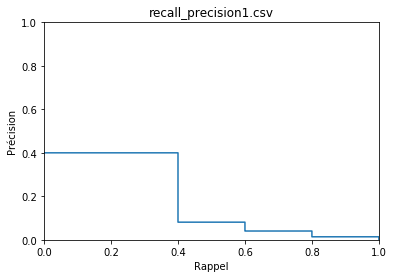

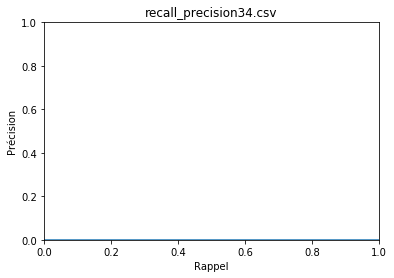

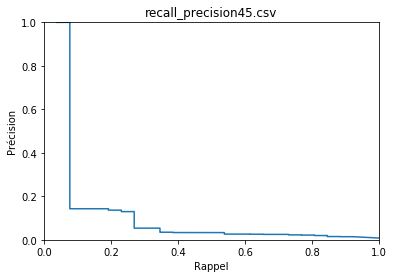

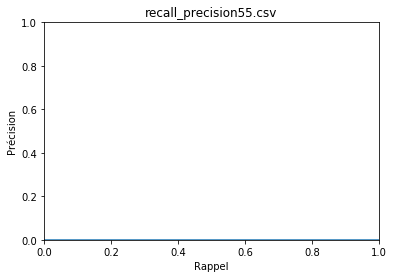

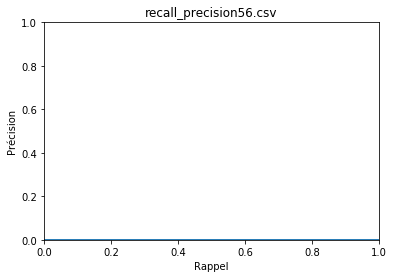

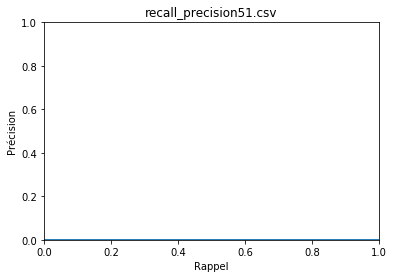

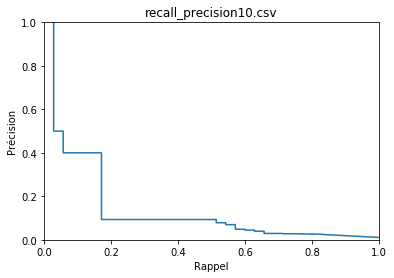

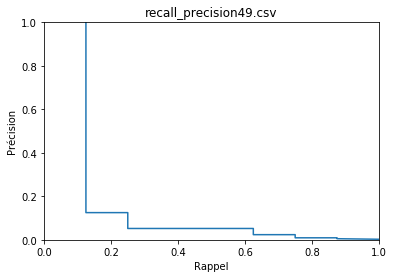

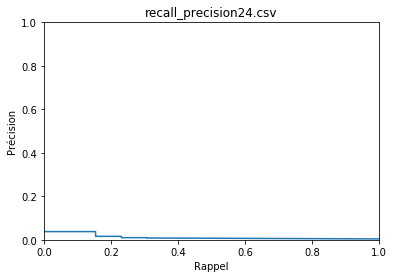

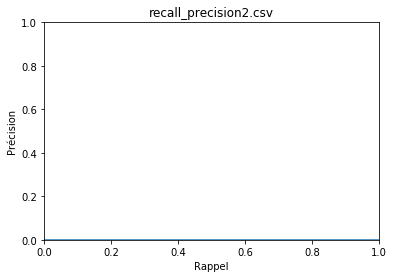

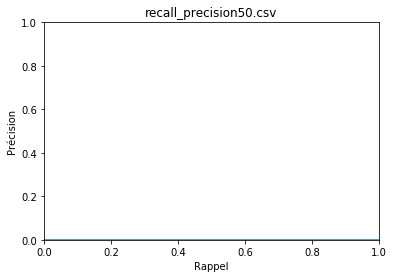

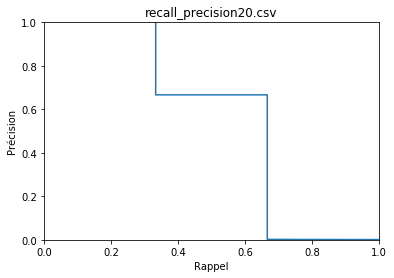

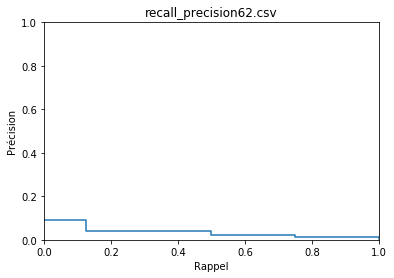

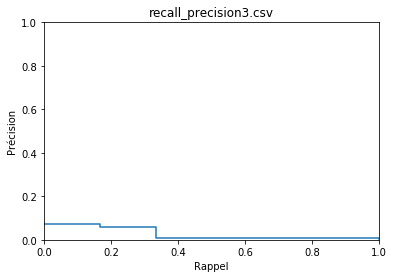

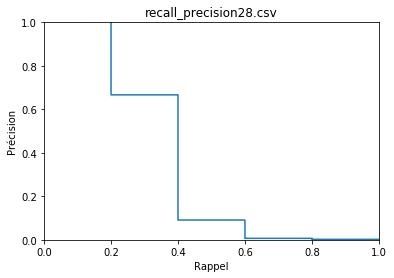

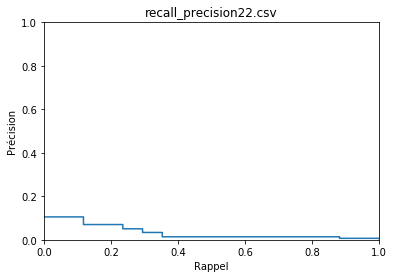

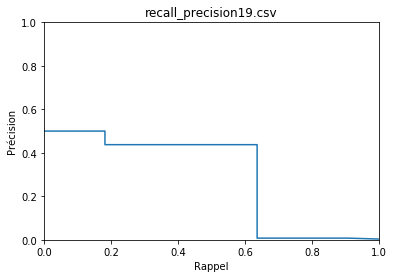

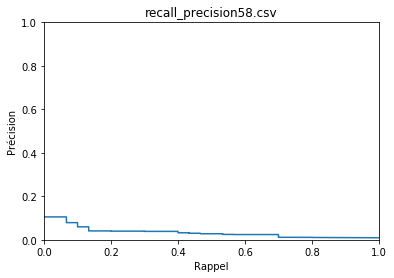

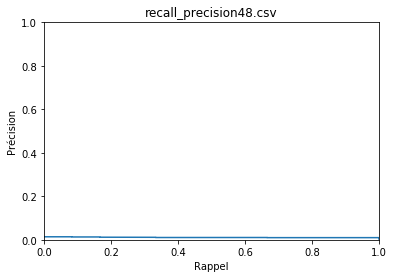

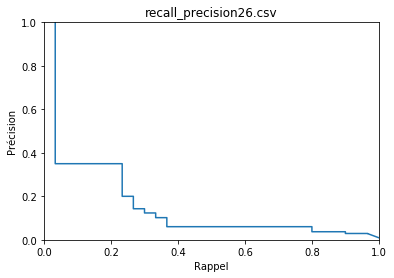

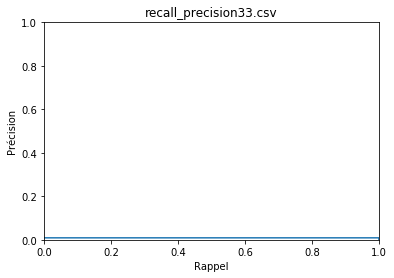

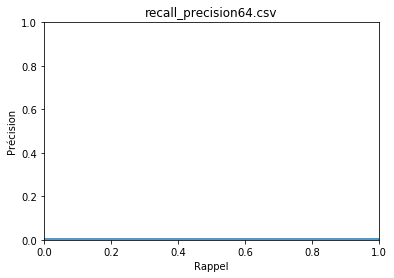

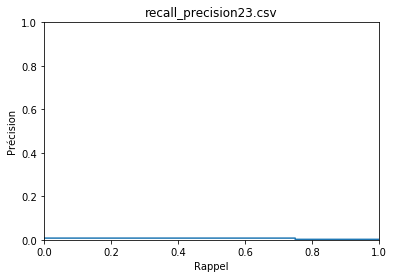

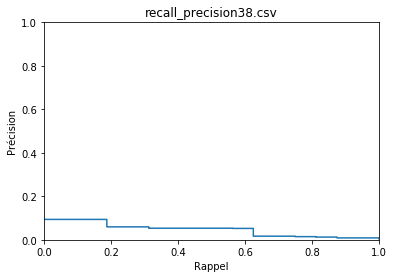

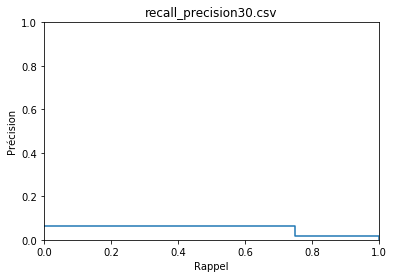

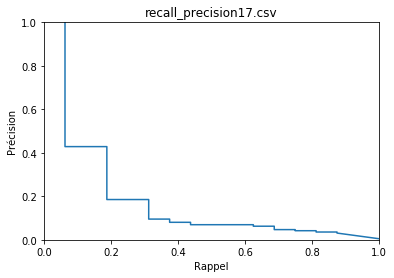

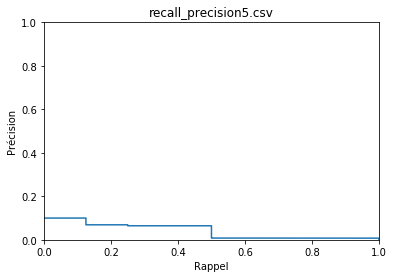

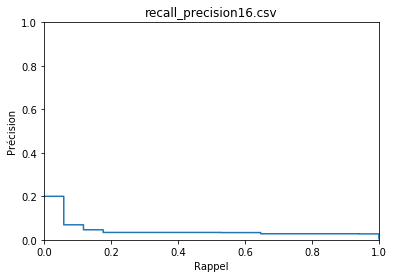

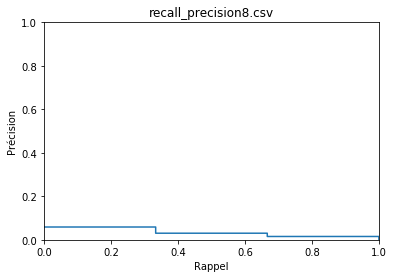

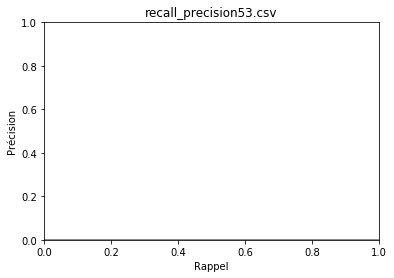

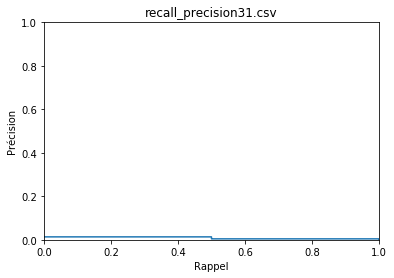

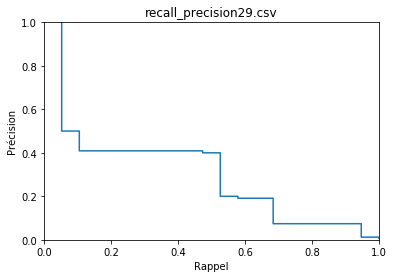

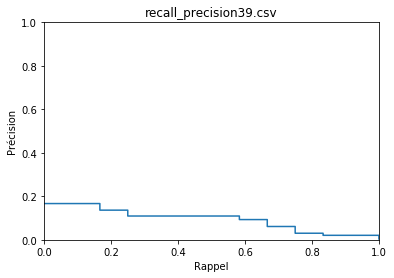

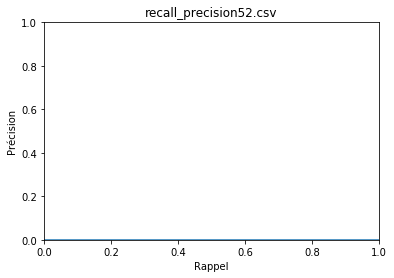

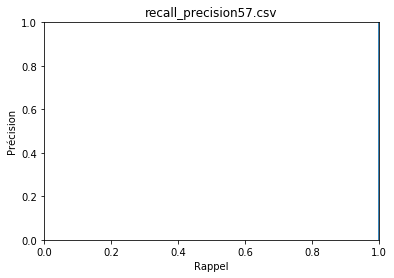

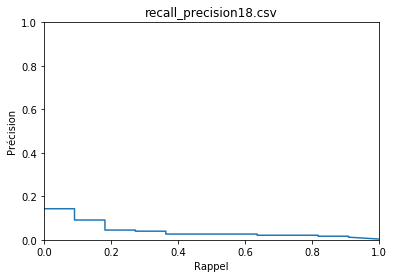

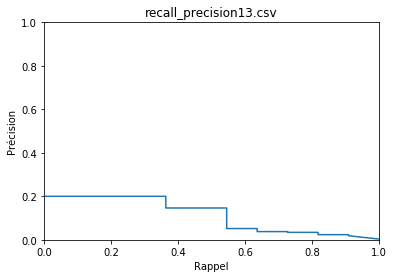

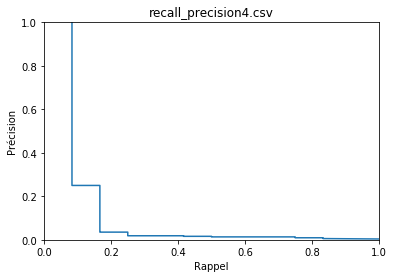

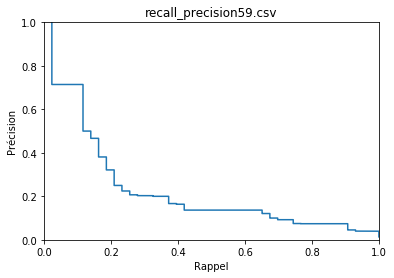

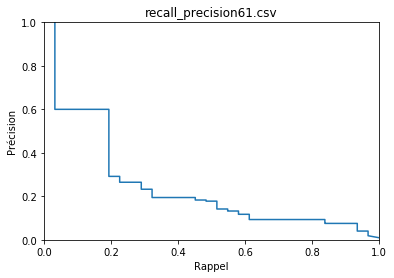

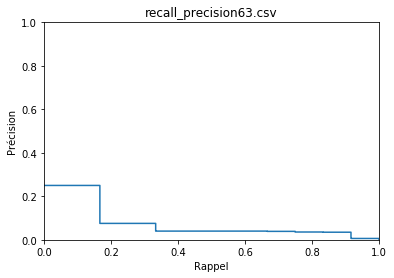

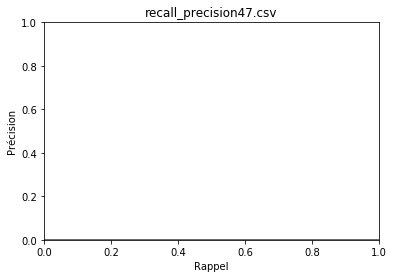

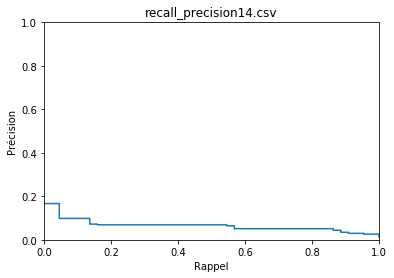

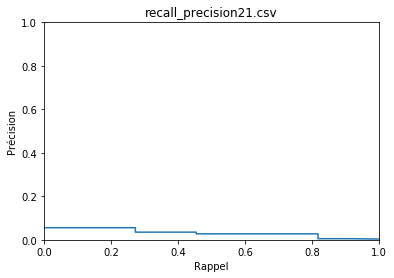

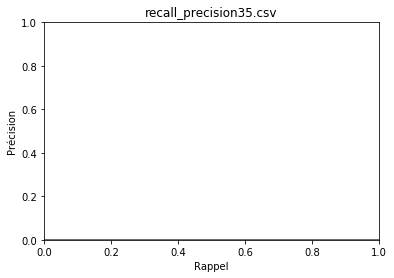

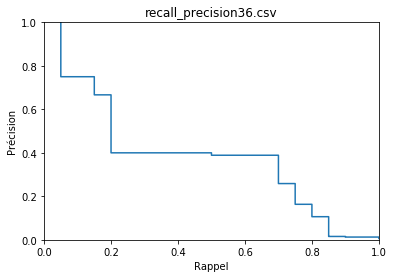

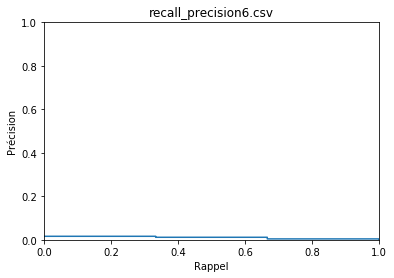

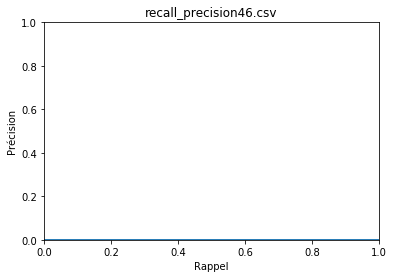

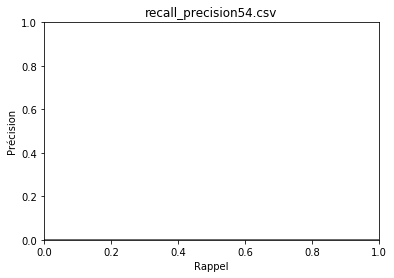

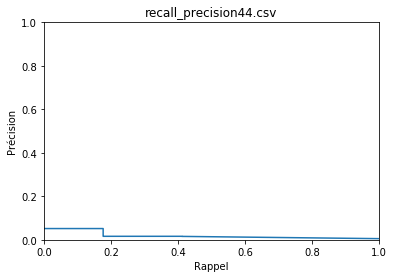

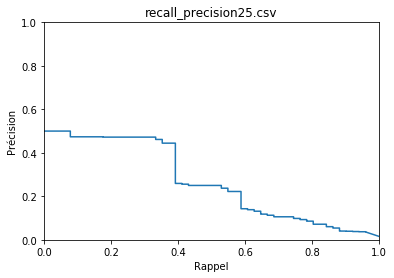

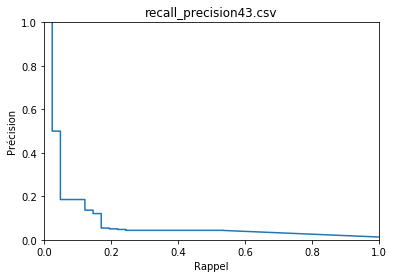

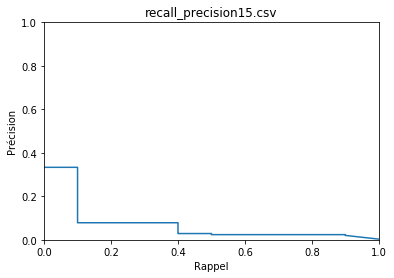

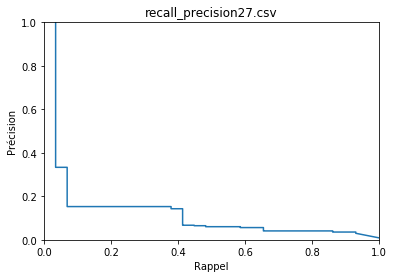

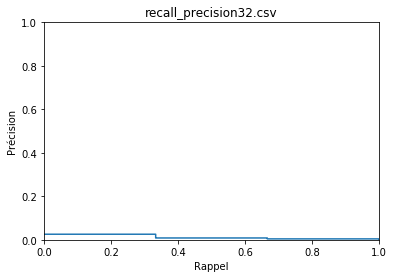

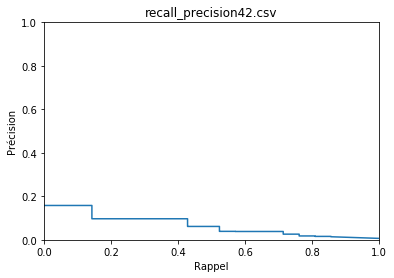

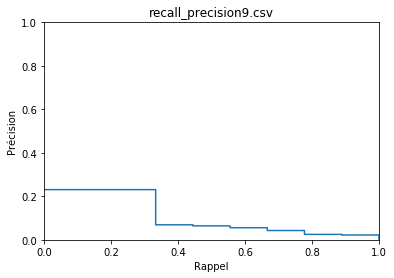

In [54]:
for path in os.listdir(data_folder):
    scores = pd.read_csv(os.path.join(data_folder, path))
    recall_scores = scores.recall.as_matrix()
    prec_scores = scores.precision.as_matrix()
    recall_precision_fig(path, recall_scores, prec_scores)

## Superposition des courbes

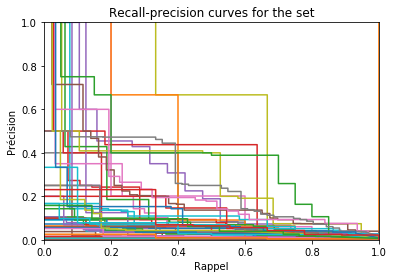

In [55]:
for path in os.listdir(data_folder):
    scores = pd.read_csv(os.path.join(data_folder, path))
    recall_scores = scores.recall.as_matrix()
    prec_scores = scores.precision.as_matrix()
    recall_precision_fig("Recall-precision curves for the set", recall_scores, prec_scores, new_fig=False)

## Interpolation pour l'ensemble des requêtes de test

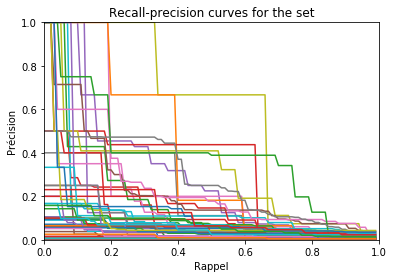

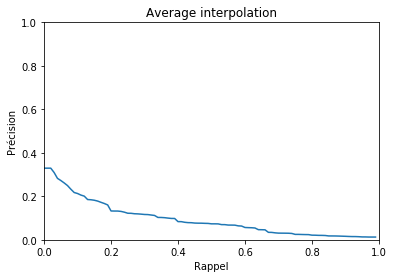

In [56]:
# Points to plot
x_plot = np.arange(0., 1., 0.01)

# Interpolation functions
interp_ys = np.array([0. for i in range(len(x_plot))])

# Fill the y list with the data
for i, path in enumerate(os.listdir(data_folder)):
    scores = pd.read_csv(os.path.join(data_folder, path))
    recall_scores = scores.recall.as_matrix()
    prec_scores = scores.precision.as_matrix()
    
    f = interpolate.interp1d(recall_scores, prec_scores, kind="zero", fill_value="extrapolate")
    
    interp_y = f(x_plot)
    interp_ys += interp_y
    
    recall_precision_fig("Recall-precision curves for the set", x_plot, interp_y, new_fig=False)

# Average interpolation

avg_y = interp_ys / len(os.listdir(data_folder))
recall_precision_fig("Average interpolation", x_plot, avg_y)

## Interpolation pour les requêtes qui ont un ensemble de réponses attendues non vide
Dans la suite de ce notebook, nous ne considérerons que les documents de test qui ont un ensemble de réponses attendues non vide.

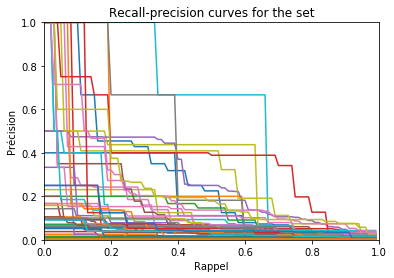

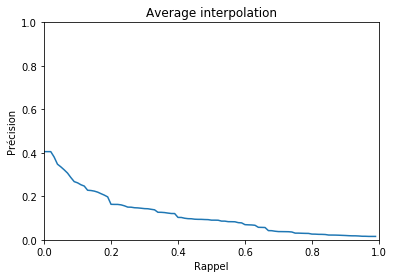

In [57]:
# Points to plot
x_plot = np.arange(0., 1., 0.01)

# Interpolation functions
interp_ys = np.array([0. for i in range(len(x_plot))])

# Requests that have an empty expected output
empty_req = [34, 35, 41, 46, 47, 50, 51, 52, 53, 54, 55, 56]

# Paths to the requests that don't have an empty expected output
non_empty_requests = [os.path.join(data_folder, "recall_precision{}.csv".format(i)) for i in range(1, 65) if i not in empty_req]

# Fill the y list with the data
for i, path in enumerate(non_empty_requests):
    scores = pd.read_csv(path)
    recall_scores = scores.recall.as_matrix()
    prec_scores = scores.precision.as_matrix()
    
    f = interpolate.interp1d(recall_scores, prec_scores, kind="zero", fill_value="extrapolate")
    
    interp_y = f(x_plot)
    interp_ys += interp_y
    
    recall_precision_fig("Recall-precision curves for the set", x_plot, interp_y, new_fig=False)

# Average interpolation
avg_y = interp_ys / len(non_empty_requests)
recall_precision_fig("Average interpolation", x_plot, avg_y)

# 2. E-mesure et F-mesure

In [58]:
def emeasure(recall, precision, alpha=0.5):
    """
    Returns the e-measure computed from a (recall, precions) point
    """
    if recall!=0 and precision!=0:
        emeasure = 1. - 1./(alpha*1./precision + (1-alpha)/recall)
    else:
        emeasure = 1
    return emeasure

def fmeasure(recall, precision, beta=1):
    """
    Returns the f-measure computed from a (recall, precions) point
    """
    if recall!=0 and precision!=0:
        fmeasure = (beta**2+1)*precision*recall / (beta**2*precision + recall)
    else:
        fmeasure = 0
    return fmeasure

## E mesure

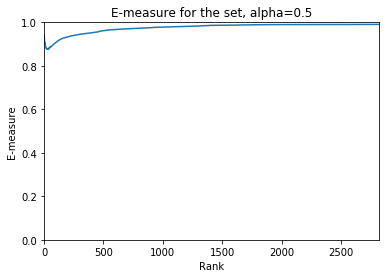

In [59]:
# Requests that have an empty expected output
empty_req = [34, 35, 41, 46, 47, 50, 51, 52, 53, 54, 55, 56]

# Paths to the requests that don't have an empty expected output
non_empty_requests = [os.path.join(data_folder, "recall_precision{}.csv".format(i)) for i in range(1, 65) if i not in empty_req]

# Initiate the e_measures
e_measures = list()

# Fill the y list with the data
for i, path in enumerate(non_empty_requests):
    scores = pd.read_csv(path)
    recall_scores = scores.recall.as_matrix()
    prec_scores = scores.precision.as_matrix()
    
    # Get the E-measure
    e_measure = [emeasure(recall_scores[j], prec_scores[j]) for j in range(len(recall_scores))]
    e_measure = np.asarray(e_measure)
    e_measure = np.flip(e_measure, 0)
    
    # Add to the f_measures list
    e_measures.append(e_measure)
    max_len = max(max_len, len(e_measure))

k = np.arange(0, max_len, 1)

for i, e_measure in enumerate(e_measures):
    missing = max_len - len(e_measure)
    if missing>0:
        to_add = np.asarray([e_measure[-1] for i in range(missing)])
        e_measure = np.concatenate((e_measure, to_add))
        e_measures[i] = e_measure
e_measures = np.asarray(e_measures)
e_measures = e_measures.mean(axis=0)

# Plot the E-measure for this request
x01_y01_fig("E-measure for the set, alpha=0.5", "Rank", k, "E-measure", e_measures, xlim=(0, len(k)))

## F mesure

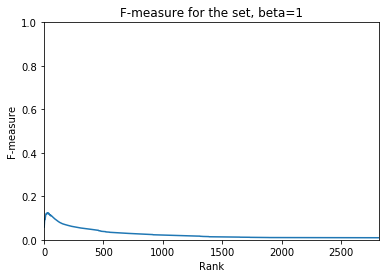

In [60]:
# Requests that have an empty expected output
empty_req = [34, 35, 41, 46, 47, 50, 51, 52, 53, 54, 55, 56]

# Paths to the requests that don't have an empty expected output
non_empty_requests = [os.path.join(data_folder, "recall_precision{}.csv".format(i)) for i in range(1, 65) if i not in empty_req]

# Initiate the e_measures
f_measures = list()
max_len = 0

# Fill the y list with the data
for i, path in enumerate(non_empty_requests):
    scores = pd.read_csv(path)
    recall_scores = scores.recall.as_matrix()
    prec_scores = scores.precision.as_matrix()
    
    # Get the E-measure
    f_measure = [fmeasure(recall_scores[j], prec_scores[j]) for j in range(len(recall_scores))]
    f_measure = np.asarray(f_measure)
    f_measure = np.flip(f_measure, 0)
    
    # Add to the f_measures list
    f_measures.append(f_measure)
    max_len = max(max_len, len(f_measure))

k = np.arange(0, max_len, 1)

for i, f_measure in enumerate(f_measures):
    missing = max_len - len(f_measure)
    if missing>0:
        to_add = np.asarray([f_measure[-1] for i in range(missing)])
        f_measure = np.concatenate((f_measure, to_add))
        f_measures[i] = f_measure
f_measures = np.asarray(f_measures)
f_measures = f_measures.mean(axis=0)

# Plot the E-measure for this request
x01_y01_fig("F-measure for the set, beta=1", "Rank", k, "F-measure", f_measures, xlim=(0, len(k)))

# 3. Mean average precision

In [61]:
# Requests that have an empty expected output
empty_req = [34, 35, 41, 46, 47, 50, 51, 52, 53, 54, 55, 56]

# Paths to the requests that don't have an empty expected output
non_empty_requests = [os.path.join(data_folder, "recall_precision{}.csv".format(i)) for i in range(1, 65) if i not in empty_req]

# Initiate the mean average precision
mean_av_prec = 0.

# Fill the y list with the data
for i, path in enumerate(non_empty_requests):
    scores = pd.read_csv(path)
    recall_scores = scores.recall.as_matrix()
    prec_scores = scores.precision.as_matrix()
    
    # Find the point from which the recall is 1.
    for i, recall_score in enumerate(recall_scores):
        if recall_score < 1.:
            if i >= 1:
                recall_one = i-1
            else:
                recall_one = 0

    # Extract useful data
    prec_scores = np.asarray(prec_scores[i:])
    mean_precision = prec_scores.mean()
    mean_av_prec += mean_precision

# Divide the result by the number of documents used
mean_av_prec = mean_av_prec / len(non_empty_requests)
print("The mean average precision on the documents with non-empty expected response is {0:.0f}%".format(mean_av_prec*100))

The mean average precision on the documents with non-empty expected response is 42%
